In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statistics

warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [3]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
df=pd.read_excel('datasets/Data.xlsx')

In [5]:
df.head()

,Unnamed: 0,graphic card type,communications,resolution (px),CPU cores,RAM size,operating system,drive type,input devices,multimedia,RAM type,CPU clock speed (GHz),CPU model,state,drive memory size (GB),warranty,screen size,buynow_price
0,7233,dedicated graphics,"['bluetooth', 'lan 10/100/1000 mbps']",1920 x 1080,4,32 gb,['no system'],ssd + hdd,"['keyboard', 'touchpad', 'illuminated keyboard...","['SD card reader', 'camera', 'speakers', 'micr...",ddr4,2.6,intel core i7,new,1250.0,producer warranty,"17"" - 17.9""",4999.0
1,5845,dedicated graphics,"['wi-fi', 'bluetooth', 'lan 10/100 mbps']",1366 x 768,4,8 gb,['windows 10 home'],ssd,"['keyboard', 'touchpad', 'numeric keyboard']","['SD card reader', 'camera', 'speakers', 'micr...",ddr3,2.4,intel core i7,new,256.0,seller warranty,"15"" - 15.9""",2649.0
2,10303,NaN,"['bluetooth', 'nfc (near field communication)']",1920 x 1080,2,8 gb,['windows 10 home'],hdd,NaN,['SD card reader'],ddr4,1.6,intel core i7,new,1000.0,producer warranty,"15"" - 15.9""",3399.0
3,10423,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new,NaN,producer warranty,NaN,1599.0
4,5897,integrated graphics,"['wi-fi', 'bluetooth']",2560 x 1440,4,8 gb,['windows 10 home'],ssd,"['keyboard', 'touchpad', 'illuminated keyboard']","['SD card reader', 'camera', 'speakers', 'micr...",ddr4,1.2,other CPU,new,256.0,producer warranty,"12"" - 12.9""",4499.0


In [6]:
df.shape

(7853, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853 entries, 0 to 7852
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              7853 non-null   int64  
 1   graphic card type       7357 non-null   object 
 2   communications          7071 non-null   object 
 3   resolution (px)         7245 non-null   object 
 4   CPU cores               7853 non-null   object 
 5   RAM size                7403 non-null   object 
 6   operating system        7203 non-null   object 
 7   drive type              7418 non-null   object 
 8   input devices           7175 non-null   object 
 9   multimedia              7145 non-null   object 
 10  RAM type                6989 non-null   object 
 11  CPU clock speed (GHz)   6917 non-null   float64
 12  CPU model               7320 non-null   object 
 13  state                   7853 non-null   object 
 14  drive memory size (GB)  7372 non-null   

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

Unnamed: 0                  0
graphic card type         496
communications            782
resolution (px)           608
CPU cores                   0
RAM size                  450
operating system          650
drive type                435
input devices             678
multimedia                708
RAM type                  864
CPU clock speed (GHz)     936
CPU model                 533
state                       0
drive memory size (GB)    481
warranty                    0
screen size               346
buynow_price                0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
format_col = ['communications','operating system','multimedia']

In [12]:
for i in format_col:
    df[i] = df[i].str.replace("[\[\]']", "", regex=True)

In [13]:
for i in df.columns:
    print(f"Unique Values for Columns:{i} is {df[i].unique()}")
    print("----------------------------------------------------------")

Unique Values for Columns:Unnamed: 0 is [7233 5845 5897 ... 2072 4741 6980]
----------------------------------------------------------
Unique Values for Columns:graphic card type is ['dedicated graphics' 'integrated graphics']
----------------------------------------------------------
Unique Values for Columns:communications is ['bluetooth, lan 10/100/1000 mbps' 'wi-fi, bluetooth, lan 10/100 mbps'
 'wi-fi, bluetooth' 'wi-fi, bluetooth, lan 10/100/1000 mbps'
 'wi-fi 802.11 b/g/n/ac, bluetooth, lan 10/100/1000 mbps'
 'bluetooth, lan 10/100 mbps'
 'bluetooth, lan 10/100/1000 mbps, lan 10/100 mbps, intel wireless display (widi), nfc (near field communication), modem 3g (wwan)'
 'bluetooth' 'lan 10/100 mbps, nfc (near field communication), gps'
 'bluetooth, lan 10/100/1000 mbps, lan 10/100 mbps, intel wireless display (widi), nfc (near field communication)'
 'lan 10/100 mbps, nfc (near field communication)'
 'wi-fi 802.11 a/b/g/n/ac, bluetooth, lan 10/100/1000 mbps'
 'bluetooth, nfc (near f

#### Finding for the above data
1. `'Unnamed: 0','state' Columns are not going to add value to dataset hence dropping the values`
1. `There are several columns to include None and nan values. We can not process them in a machine learning model. We will drop it since we don't have a solid knowledge to fill it all`
1. `The columns of communications, input_devices and multimedia include multiple values in a cell in list format. We can not represent them in numerics in its current format. We will split the values of these columns into different columns.`

In [14]:
df['X_res']=df['resolution (px)'].str.split('x',n=1,expand=True)[0]
df['Y_res']=df['resolution (px)'].str.split('x',n=1,expand=True)[1]
df['RAM size']=df['RAM size'].str.replace('gb','')
df['RAM type']=df['RAM type'].str.replace('l','')

In [15]:
df['screen size']=df['screen size'].str.extract(r'(\d+)').astype(int)


In [16]:
df['CPU cores']=df['CPU cores'].astype(int)
df['RAM size']=df['RAM size'].astype(int)
df['X_res']=df['X_res'].astype(int)
df['Y_res']=df['Y_res'].astype(int)
df['screen size']=df['screen size'].astype(int)

In [17]:
df['ppi'] = round(np.sqrt(df['X_res']**2 + df['Y_res']**2) / df['screen size'],2)

In [18]:
df.drop(columns=['X_res','Y_res'],inplace=True)

In [19]:
df['bluetooth'] = df['communications'].apply(lambda x:1 if 'bluetooth' in x else 0)
df['wifi'] = df['communications'].apply(lambda x:1 if 'wi-fi' in x else 0)
df['lan'] = df['communications'].apply(lambda x:1 if 'lan' in x else 0)


In [20]:
df['windows'] = df['operating system'].apply(lambda x:1 if 'windows' in x else 0)
df['linux'] = df['operating system'].apply(lambda x:1 if 'linux' in x else 0)
df['other'] = df['operating system'].apply(lambda x:1 if 'other' in x else 0)
df['no system'] = df['operating system'].apply(lambda x:1 if 'no system' in x else 0)

In [21]:
# Check if 'windows' equals 1 and 'other' equals 1
mask = (df['windows'] == 1) & (df['other'] == 1)
# Set 'other' to 0 where the condition is true
df.loc[mask, 'other'] = 0

In [22]:
df['hdd'] = df['drive type'].apply(lambda x:1 if 'hdd' in x else 0)
df['ssd'] = df['drive type'].apply(lambda x:1 if 'ssd' in x else 0)
df['emmc'] = df['drive type'].apply(lambda x:1 if 'emmc' in x else 0)
df['hybrid'] = df['drive type'].apply(lambda x:1 if 'hybrid' in x else 0)

In [23]:
df['keyboard'] = df['input devices'].apply(lambda x:1 if "'keyboard'" in x else 0)
df['touchpad'] = df['input devices'].apply(lambda x:1 if "'touchpad'" in x else 0)
df['numeric keyboard'] = df['input devices'].apply(lambda x:1 if "'numeric keyboard'" in x else 0)
df['illuminated keyboard'] = df['input devices'].apply(lambda x:1 if "'illuminated keyboard'" in x else 0)

In [24]:
drop_cols=['Unnamed: 0','state','resolution (px)','communications','operating system','drive type','input devices','multimedia']

In [25]:
df.drop(columns=drop_cols,inplace=True)

In [26]:
df.sample()

,graphic card type,CPU cores,RAM size,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,screen size,buynow_price,...,other,no system,hdd,ssd,emmc,hybrid,keyboard,touchpad,numeric keyboard,illuminated keyboard
599,integrated graphics,2,8,ddr3,2.3,intel core i5,120.0,producer warranty,15,2749.0,...,0,0,0,1,0,0,0,1,0,0


In [27]:
df.shape

(6109, 26)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6109 entries, 0 to 7850
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   graphic card type       6109 non-null   object 
 1   CPU cores               6109 non-null   int32  
 2   RAM size                6109 non-null   int32  
 3   RAM type                6109 non-null   object 
 4   CPU clock speed (GHz)   6109 non-null   float64
 5   CPU model               6109 non-null   object 
 6   drive memory size (GB)  6109 non-null   float64
 7   warranty                6109 non-null   object 
 8   screen size             6109 non-null   int32  
 9   buynow_price            6109 non-null   float64
 10  ppi                     6109 non-null   float64
 11  bluetooth               6109 non-null   int64  
 12  wifi                    6109 non-null   int64  
 13  lan                     6109 non-null   int64  
 14  windows                 6109 non-null   

In [29]:
df.to_excel('cleaned.xlsx')

<AxesSubplot:xlabel='buynow_price', ylabel='Density'>

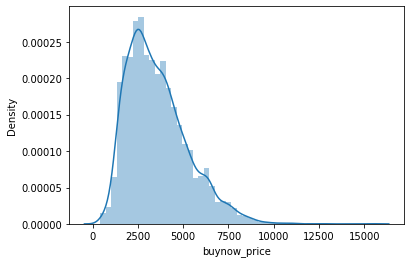

In [30]:
sns.distplot(df['buynow_price'])

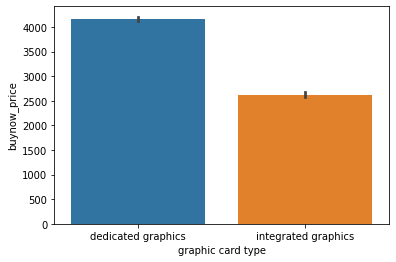

In [31]:
sns.barplot(x=df['graphic card type'],y=df['buynow_price'])
plt.show()

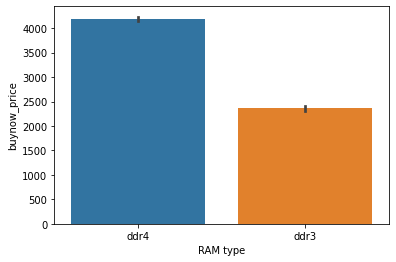

In [32]:
sns.barplot(x=df['RAM type'],y=df['buynow_price'])
plt.show()

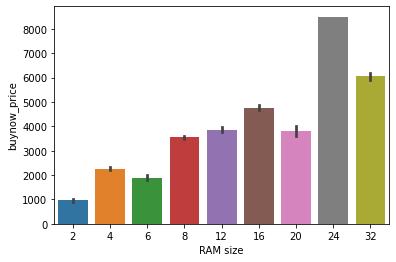

In [33]:
sns.barplot(x=df['RAM size'],y=df['buynow_price'])
plt.show()

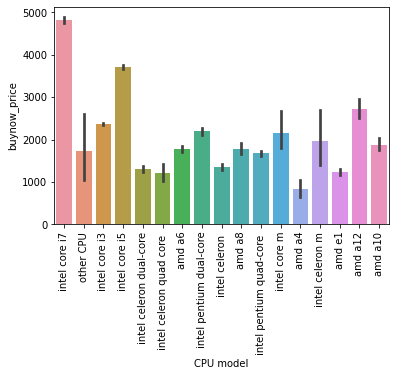

In [34]:
sns.barplot(x=df['CPU model'],y=df['buynow_price'])
plt.xticks(rotation='vertical')
plt.show()

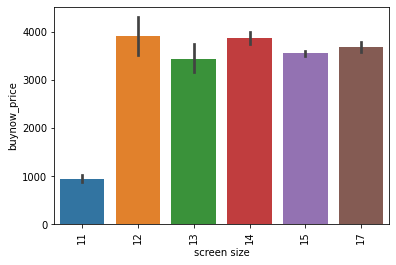

In [35]:
sns.barplot(x=df['screen size'],y=df['buynow_price'])
plt.xticks(rotation='vertical')
plt.show()

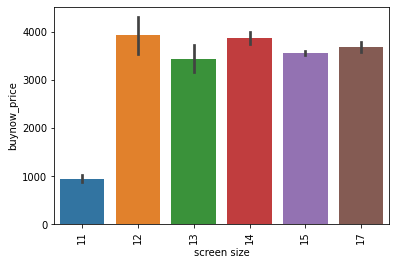

In [36]:
sns.barplot(x=df['screen size'],y=df['buynow_price'])
plt.xticks(rotation='vertical')
plt.show()

<AxesSubplot:xlabel='screen size', ylabel='Density'>

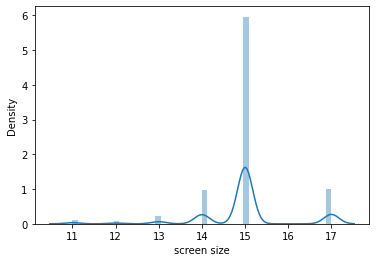

In [37]:
sns.distplot(df['screen size'])

<AxesSubplot:xlabel='screen size', ylabel='buynow_price'>

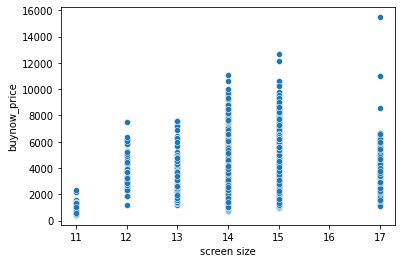

In [38]:
sns.scatterplot(x=df['screen size'],y=df['buynow_price'])


<AxesSubplot:>

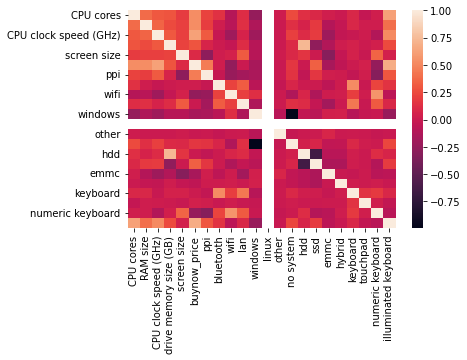

In [61]:
sns.heatmap(df.corr())

<AxesSubplot:>

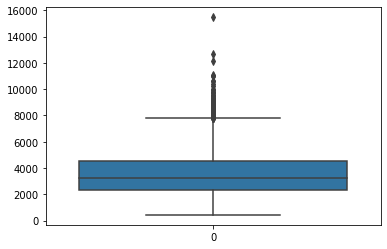

In [40]:
sns.boxplot(data=df['buynow_price'])

In [41]:
df.sample()

,graphic card type,CPU cores,RAM size,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,screen size,buynow_price,...,other,no system,hdd,ssd,emmc,hybrid,keyboard,touchpad,numeric keyboard,illuminated keyboard
4684,dedicated graphics,4,12,ddr4,1.8,intel core i7,256.0,producer warranty,15,4419.0,...,0,1,0,1,0,0,1,1,0,0


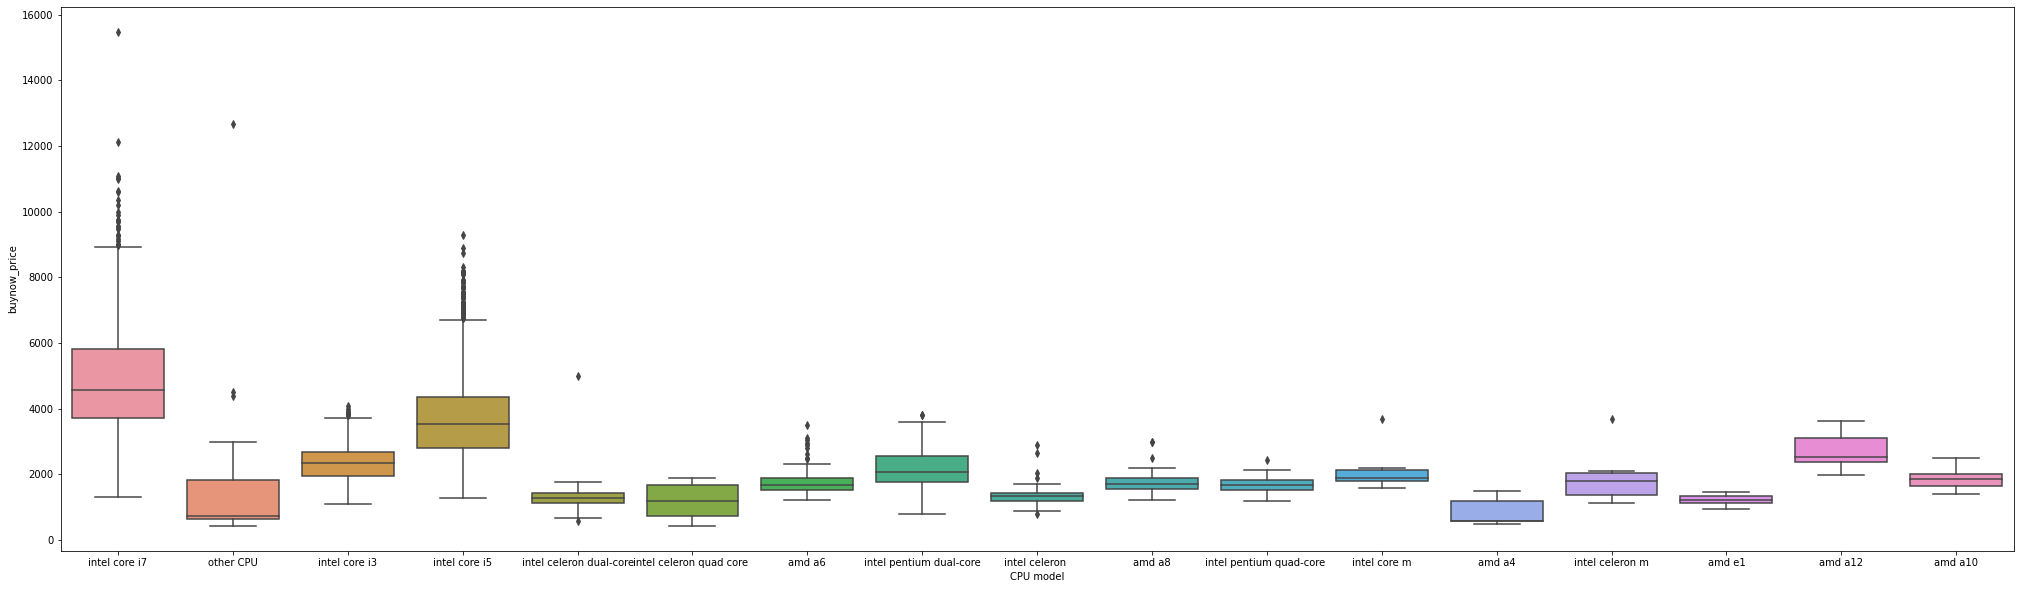

In [42]:
plt.figure(figsize=(35,10))
sns.boxplot(x='CPU model', y='buynow_price', data=df)
plt.xticks(rotation='horizontal')
plt.show()

In [43]:
Q1 = np.percentile(df['buynow_price'], 25)
Q3 = np.percentile(df['buynow_price'], 75)
IQR = Q3-Q1

In [44]:
Lowerfence = Q1-1.5*IQR
Upperfence = Q3+1.5*IQR

In [45]:
Upperfence

7784.0

In [46]:
med = np.median(df['buynow_price'])

In [47]:
df.loc[df['buynow_price'] > Upperfence, 'buynow_price'] = med
df.loc[df['buynow_price'] < Lowerfence, 'buynow_price'] = med

<AxesSubplot:xlabel='buynow_price', ylabel='Density'>

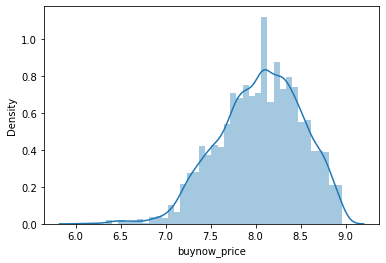

In [48]:
sns.distplot(np.log(df['buynow_price']))


In [49]:
X = df.drop(columns=['buynow_price'])
y = np.log(df['buynow_price'])

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=2)

In [51]:
X_train

,graphic card type,CPU cores,RAM size,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,screen size,ppi,...,other,no system,hdd,ssd,emmc,hybrid,keyboard,touchpad,numeric keyboard,illuminated keyboard
1396,integrated graphics,2,8,ddr4,2.5,intel core i5,1128.0,producer warranty,15,146.86,...,0,0,1,1,0,0,1,1,1,0
5088,dedicated graphics,4,32,ddr4,2.8,intel core i7,960.0,producer warranty,15,146.86,...,0,0,0,1,0,0,1,1,0,1
774,integrated graphics,2,2,ddr3,1.6,intel celeron,32.0,producer warranty,11,142.46,...,0,0,0,1,0,0,1,1,0,0
5864,dedicated graphics,2,8,ddr3,2.0,intel core i7,1000.0,seller warranty,15,146.86,...,0,0,0,0,0,1,1,1,1,0
3397,dedicated graphics,2,12,ddr4,2.7,intel core i7,1000.0,producer warranty,15,146.86,...,0,0,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,dedicated graphics,4,16,ddr4,2.8,intel core i7,1128.0,producer warranty,15,146.86,...,0,1,1,1,0,0,1,1,1,1
3164,dedicated graphics,4,8,ddr4,2.8,intel core i7,512.0,producer warranty,15,146.86,...,0,0,0,1,0,0,1,1,0,1
4599,integrated graphics,2,8,ddr4,2.5,intel core i5,256.0,producer warranty,14,157.35,...,0,0,0,1,0,0,1,1,0,1
7335,dedicated graphics,2,8,ddr3,2.3,intel core i5,1628.0,producer warranty,17,129.58,...,0,0,1,1,0,0,1,1,0,0


# Model Building

## Linear Regression

In [52]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = LinearRegression()

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.18408866223145284
R2 score 0.8391841000697197
MAE 0.13505841373778849


## Ridge Regression

In [53]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = Ridge(alpha=10)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.18694424747997215
R2 score 0.8341562483171016
MAE 0.13682326245648682


## Lasso Regression

In [54]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = Lasso(alpha=0.001)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.19078282513076833
R2 score 0.8272756953058719
MAE 0.13907383981690896


## KNN

In [55]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = KNeighborsRegressor(n_neighbors=3)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.175673172043473
R2 score 0.8535512098006105
MAE 0.12509611553357758


## Decision Tree

In [56]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = DecisionTreeRegressor(max_depth=8)

pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.18014282010898716
R2 score 0.8460042211970644
MAE 0.1339647129629185


## Random Forest

In [57]:
step1 = ColumnTransformer(transformers=[
    ('col_tnf',OneHotEncoder(sparse=False,drop='first'),[0,3,5,7])
],remainder='passthrough')

step2 = RandomForestRegressor(n_estimators=100,random_state=3,max_samples=0.5,max_features=0.75,max_depth=15)
pipe = Pipeline([
    ('step1',step1),
    ('step2',step2)
])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

print('RMSE',np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

RMSE 0.1367438601579829
R2 score 0.9112658950637865
MAE 0.0958890112055825


In [58]:
import pickle

In [59]:
pickle.dump(df,open('df.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(pipe,open('pipe.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)